In [4]:
%pip install -q git+https://github.com/peng-lab/BaSiCPy
%pip install -q plotly==5.4.0

^C
ERROR: Operation cancelled by user
Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 3.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 1.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 5.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.2/68.2 kB 1.0 MB/s eta 0:00:00ta 0:00:01
  Using cached pyparsing-3.1.1-py3-none-any.whl (103 kB)
Note: you may need to restart the kernel to use updated packages.


In [11]:
import numpy as np
from os import path

# from aicsimageio import AICSImage
# from aicspylibczi import CziFile
from matplotlib import pyplot as plt

plt.rcParams["font.family"] = "sans-serif"
plt.style.use("../paper_style.mplstyle")
figwidth = 3.4

import pandas as pd
from skimage.io import imread
import yaml
# from cucim.skimage.morphology import binary_erosion, disk

nuc_channel_idx = 2
cyto_channel_idx = 0


def save_and_copy_fig(fig, name):
    fig.savefig("../figs/" + name + ".pdf")
    !cp ../figs/{name}.pdf ~/myworks/papers/2305_BaSiCPy/fig2/

In [2]:
import glob

# file_path = "/content/drive/MyDrive/Colab Notebooks/BaSiCPy-dev/Simulation/simulatedimages/"
file_path = "./"
flatfield_true = np.load(
    path.join(file_path, f"flatfield_true.npy"),
)
darkfield_true = np.load(
    path.join(file_path, f"darkfield_true.npy"),
)
baseline_true = np.load(
    path.join(file_path, f"baseline_true.npy"),
)

In [12]:
with open("wo_darkfield_ground_truth_values.yaml","r") as f:
    gt_values = yaml.safe_load(f)

# Without darkfield

In [3]:
images_distorted_wo_darkfield = np.load("images_distorted_wo_darkfield_with_noise.npy")
images_distorted_wo_darkfield.shape

(2, 200, 256, 256)

cp: cannot create regular file ‘/home/fukai/myworks/papers/2305_BaSiCPy/fig2/’: No such file or directory


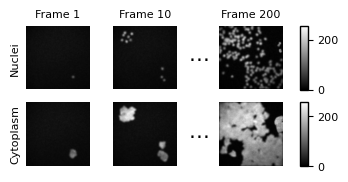

In [6]:
fig, axes = plt.subplots(
    2, 5, width_ratios=(1, 1, 0.1, 1, 0.1), figsize=(figwidth, figwidth / 2)
)
for ch, _axes in zip([0,1], axes):
    _axes[0].imshow(images_distorted_wo_darkfield[ch, 0], cmap="gray", vmin=0, vmax=255)
    _axes[1].imshow(images_distorted_wo_darkfield[ch, 9], cmap="gray", vmin=0, vmax=255)
    im = _axes[3].imshow(
        images_distorted_wo_darkfield[ch, 199], cmap="gray", vmin=0, vmax=255
    )
    fig.colorbar(im, cax=_axes[4])

axes[0, 0].set_title("Frame 1")
axes[0, 1].set_title("Frame 10")
axes[0, 3].set_title("Frame 200")
axes[0, 0].set_ylabel("Nuclei")
axes[1, 0].set_ylabel("Cytoplasm")
for ax in axes[:, :-1].ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
for ax in axes[:, 2].ravel():
    ax.axis("off")
    ax.text(
        0.5,
        0.5,
        "$\cdots$",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=15,
    )
fig.subplots_adjust(left=0.05, right=0.9, top=0.875, bottom=0.05)
save_and_copy_fig(fig, "fig2a_simulated_images_examples")

In [7]:
flatfields_wo_darks = {}
baselines_wo_darks = {}
parameters_df_wo_darks = {}
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    flatfields_wo_darks[channel_index] = np.load(
        path.join(file_path, f"wo_darkfield_flatfields_channel_{channel_index}_2.npy"),
        allow_pickle=True,
    )
    baselines_wo_darks[channel_index] = np.load(
        path.join(file_path, f"wo_darkfield_baselines_channel_{channel_index}_2.npy"),
        allow_pickle=True,
    )
    parameters_df_wo_darks[channel_index] = pd.read_csv(
        path.join(file_path, f"wo_darkfield_parameters_channel_{channel_index}_2.csv"),
        index_col=0,
    )

EOFError: No data left in file

In [8]:
parameters_df_wo_darks[0].head()

KeyError: 0

/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_16638/1834197408.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/var/folders/81/kh0zpmbd00g39vwz69lkk4mc0000gn/T/ipykernel_16638/1834197408.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


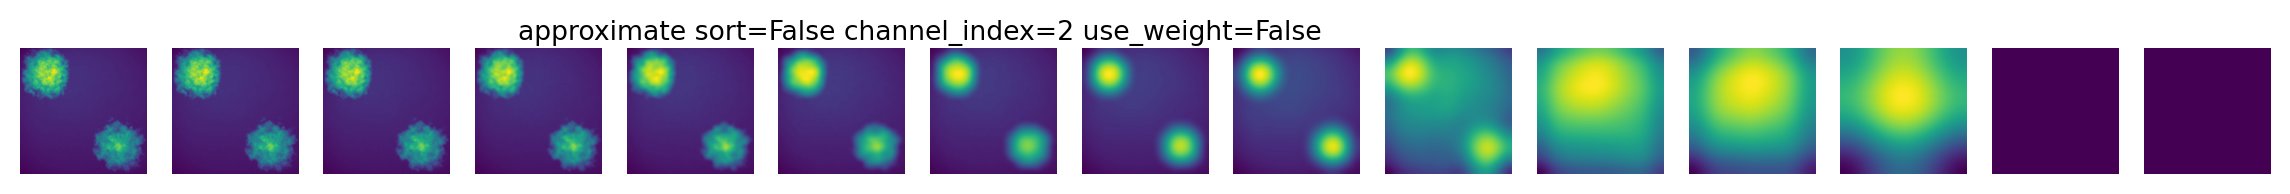

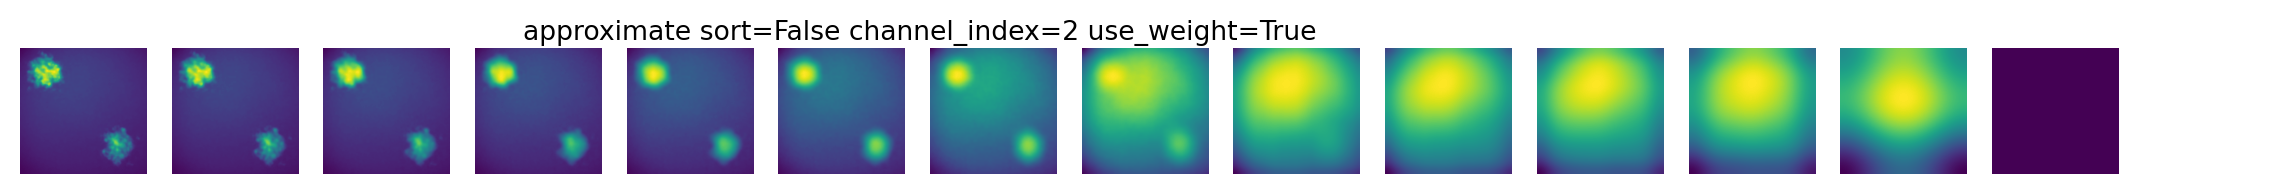

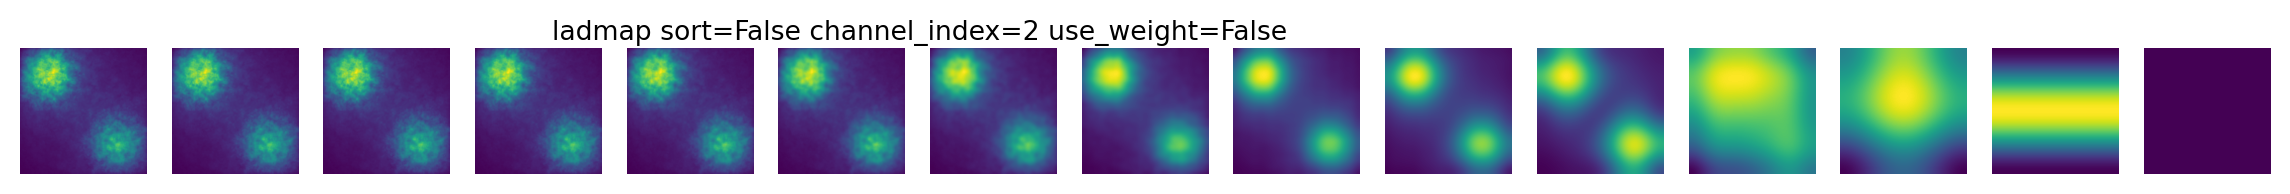

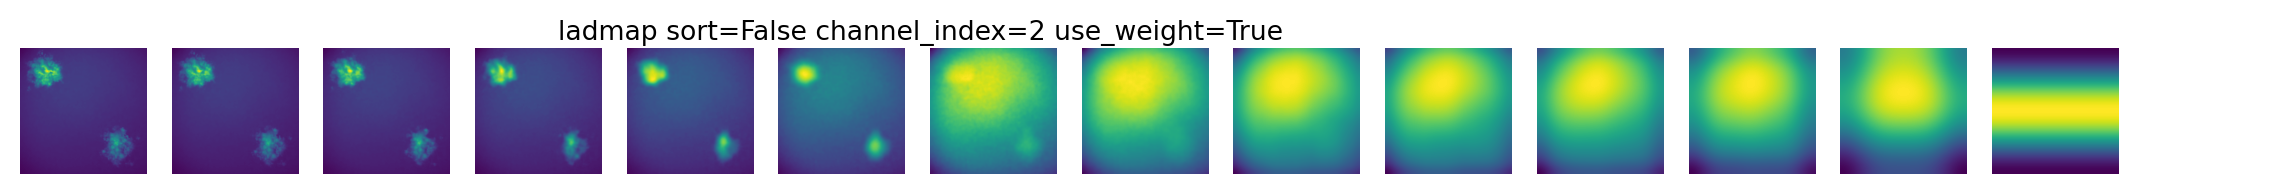

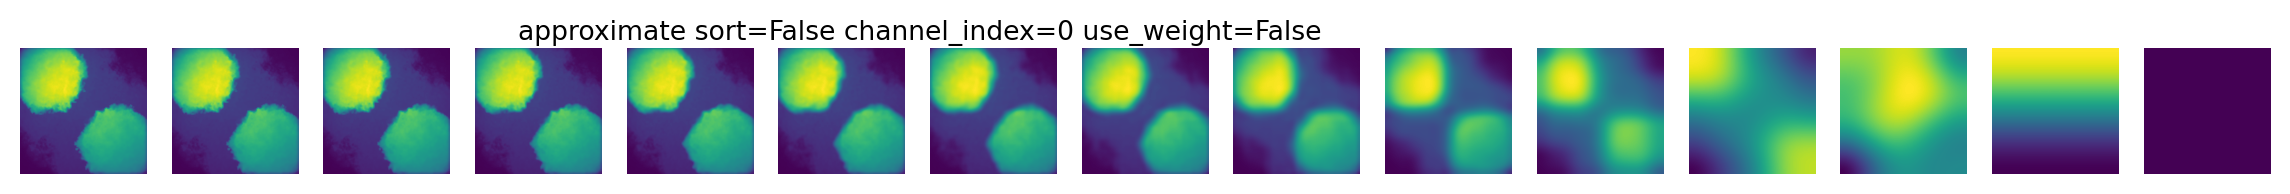

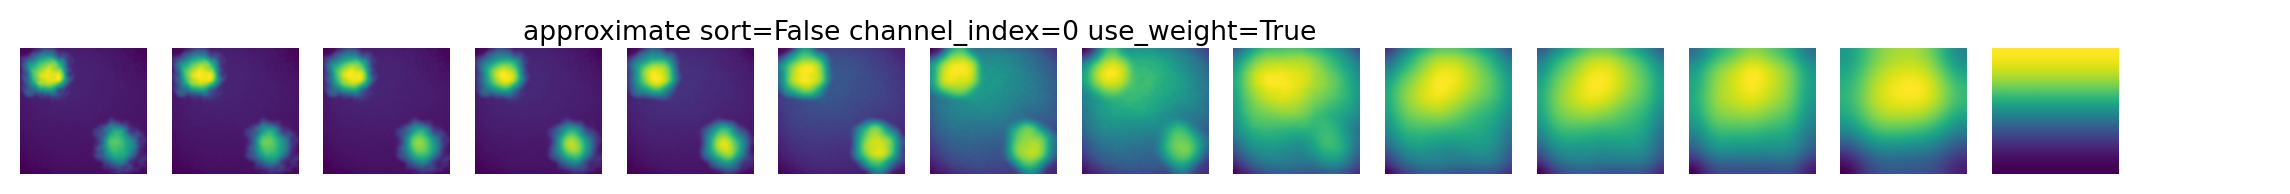

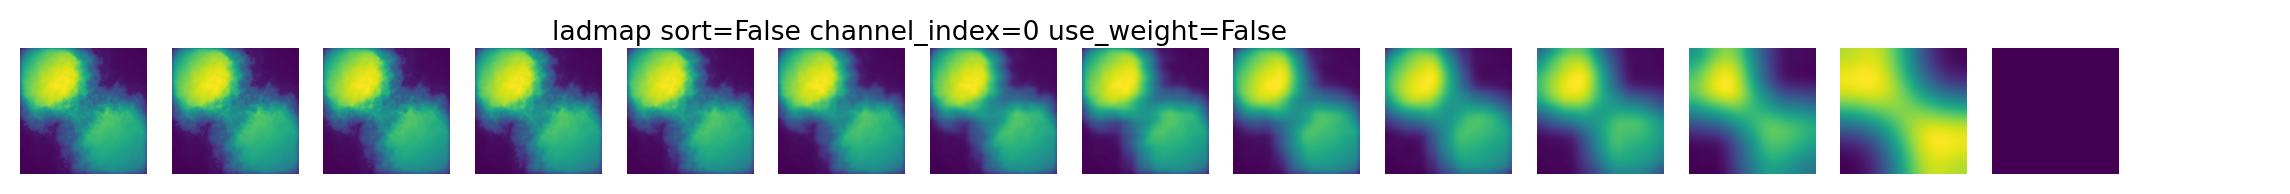

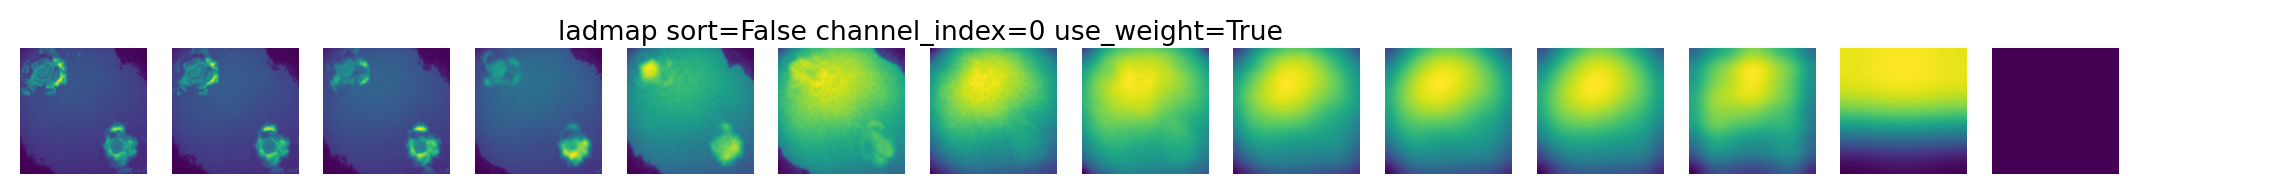

In [87]:
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    for (
        fitting_mode,
        sort_intensity,
        channel_index,
        use_weight,
    ), grp in parameters_df_wo_darks[channel_index].groupby(
        ["fitting_mode", "sort_intensity", "channel_index", "use_weight"]
    ):
        df = grp.sort_values("smoothness_flatfield").query("rep==0")
        fig, axes = plt.subplots(1, len(df), figsize=(15, 1))
        for ax, (i, row) in zip(np.ravel(axes), df.iterrows()):
            ax.imshow(flatfields_wo_darks[channel_index][i])
            ax.axis("off")
        fig.suptitle(
            f"{fitting_mode} sort={sort_intensity} channel_index={channel_index} use_weight={use_weight}"
        )
        fig.show()

In [9]:
for channel_index in [nuc_channel_idx, cyto_channel_idx]:
    for i, row in parameters_df_wo_darks[channel_index].iterrows():
        flatfield = flatfields_wo_darks[channel_index][i]
        if not np.any(np.isfinite(flatfield)):
            continue
        parameters_df_wo_darks[channel_index].loc[i, "mean_abs_error"] = np.mean(
            np.abs(flatfield_true - flatfield)
        )

KeyError: 0

In [13]:
gt_values

{0: {'autotune_cost': 1984.4856210934838,
  'entropy': 3.989639673687298,
  'fourier_L0_norm': 0.19904959814197964},
 2: {'autotune_cost': 1983.6695229502034,
  'entropy': 3.1735415304070744,
  'fourier_L0_norm': 0.19904959814197964}}

approximate False 0.04856182895677923 False
approximate True 0.020554903564114452 True
ladmap False 0.07433140540794256 False
ladmap True 0.02023944223432023 True


KeyError: 0

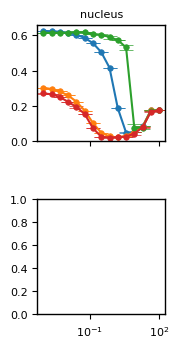

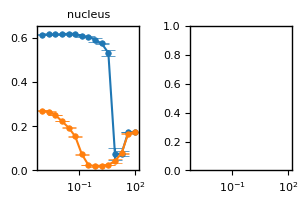

In [14]:
fig, axes = plt.subplots(
    2, 1, figsize=(3.4 / 2, 3.4), sharex=True, gridspec_kw=dict(hspace=0.5)
)
fig2, axes2 = plt.subplots(
    1, 2, figsize=(3.4, 3.4 / 2), sharex=True, gridspec_kw=dict(hspace=0.5, wspace=0.5)
)
for ax, ax2, channel_index in zip(axes, axes2, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index}"
    )
    df = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in df.groupby(["fitting_mode", "use_weight"]):
        xs = grp["smoothness_flatfield"]
        ys = grp["mean_abs_error"]["mean"]
        yerrs = grp["mean_abs_error"]["std"] * 2
        ax.errorbar(
            xs,
            ys,
            yerrs,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'} {'w/' if use_weight else 'w/o'} weights",
        )
        if fitting_mode == "ladmap":
            ax2.errorbar(
                xs,
                ys,
                yerrs,
                fmt="o-",
                label=f"{'with' if use_weight else 'without'} weights",
            )
        min_val = min(grp["mean_abs_error"]["mean"])
        print(fitting_mode, use_weight, min_val, min_val < 3e-2)
    for _ax in [ax, ax2]:
        _ax.set_xscale("log")
        # _ax.set_yscale("log")
        _ax.set_ylim(0, None)
        _ax.set_title(
            {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
        )
        _ax.axhline(gt_values[channel_index]["entropy"], color="gray", linestyle="--")
    # ax.axhline(2e-2)
fig.supylabel("Mean absolute error", x=0.025, fontsize=8.0)
axes2[0].set_ylabel("Mean absolute error", x=-0.2)
axes[1].set_xlabel("smoothness_flatfield")
fig2.supxlabel("smoothness_flatfield", fontsize=8.0, y=0.025, x=0.55)

axes[0].legend(loc="lower left", bbox_to_anchor=(-0.55, 1.2), handletextpad=0.4)
axes2[0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.2),
    handletextpad=0.4,
    ncols=2,
    columnspacing=0.5,
)

fig.subplots_adjust(left=0.35, right=0.95, top=0.75, bottom=0.15)
fig2.subplots_adjust(left=0.2, right=0.95, top=0.75, bottom=0.25)

save_and_copy_fig(fig, "figS_simulated_images_flatfield_error_all")
save_and_copy_fig(fig2, "fig2b_simulated_images_flatfield_error")

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


approximate True 0.02045591088257769 True
ladmap True 0.020256412140972603 True
approximate True 0.02456881653565026 True
ladmap True 0.01948450252752681 True


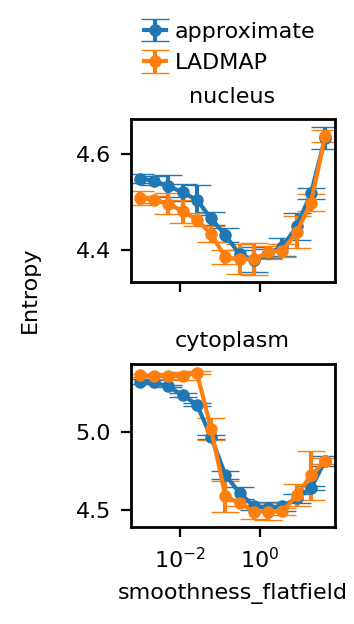

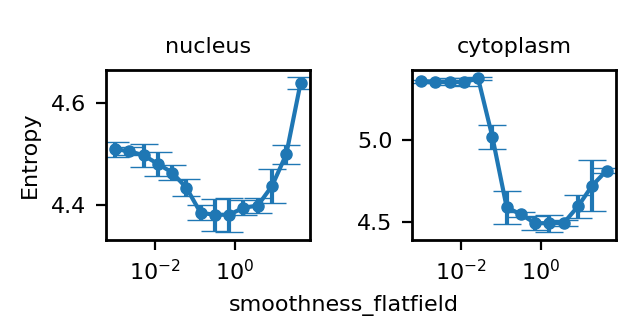

In [ ]:
fig, axes = plt.subplots(
    2, 1, figsize=(3.4 / 2, 3.4), sharex=True, gridspec_kw=dict(hspace=0.5)
)
fig2, axes2 = plt.subplots(
    1, 2, figsize=(3.4, 3.4 / 2), sharex=True, gridspec_kw=dict(hspace=0.5, wspace=0.5)
)
for ax, ax2, channel_index in zip(axes, axes2, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index} and use_weight==True"
    )
    df = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in df.groupby(["fitting_mode", "use_weight"]):
        xs = grp["smoothness_flatfield"]
        ys = grp["entropy"]["mean"]
        yerrs = grp["entropy"]["std"] * 2
        ax.errorbar(
            xs,
            ys,
            yerrs,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'}",
        )
        if fitting_mode == "ladmap":
            ax2.errorbar(
                xs,
                ys,
                yerrs,
                fmt="o-",
                # label=f"{'with' if use_weight else 'without'} weights",
            )
        min_val = min(grp["mean_abs_error"]["mean"])
        print(fitting_mode, use_weight, min_val, min_val < 3e-2)
    for _ax in [ax, ax2]:
        _ax.set_xscale("log")
        # _ax.set_yscale("log")
        # _ax.set_ylim(0,None)
        _ax.set_title(
            {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
        )
    # ax.axhline(2e-2)
fig.supylabel("Entropy", x=0.025, fontsize=8.0)
axes2[0].set_ylabel("Entropy", x=-0.2)
axes[1].set_xlabel("smoothness_flatfield")
fig2.supxlabel("smoothness_flatfield", fontsize=8.0, y=0.025, x=0.55)

axes[0].legend(loc="lower left", bbox_to_anchor=(0.0, 1.2), handletextpad=0.4)
axes2[0].legend(
    loc="lower left",
    bbox_to_anchor=(0.0, 1.2),
    handletextpad=0.4,
    ncols=2,
    columnspacing=0.5,
)

fig.subplots_adjust(left=0.35, right=0.95, top=0.75, bottom=0.15)
fig2.subplots_adjust(left=0.2, right=0.95, top=0.75, bottom=0.25)

save_and_copy_fig(fig, "figS_simulated_images_flatfield_entropy_all")
save_and_copy_fig(fig2, "fig2c_simulated_images_flatfield_entropy")

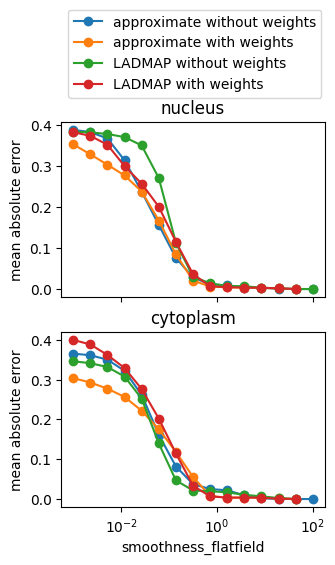

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(3.4, 5), sharex=True)
for ax, channel_index in zip(axes, [nuc_channel_idx, cyto_channel_idx]):
    df = parameters_df_wo_darks[channel_index].query(
        f"sort_intensity==False and channel_index=={channel_index}"
    )
    df = (
        df.groupby(["fitting_mode", "use_weight", "smoothness_flatfield"])
        .agg(["mean", "std"])
        .reset_index()
    )
    for (fitting_mode, use_weight), grp in df.groupby(["fitting_mode", "use_weight"]):
        ax.errorbar(
            grp["smoothness_flatfield"],
            grp["fourier_L0_norm"]["mean"],
            # grp["autotune_cost"]["std"]*2,
            fmt="o-",
            label=f"{'LADMAP' if fitting_mode=='ladmap' else 'approximate'} {'with' if use_weight else 'without'} weights",
        )
        # ax.set_ylim(4,5)
        ax.set_xscale("log")
    ax.set_ylabel("mean absolute error")
    ax.set_title(
        {nuc_channel_idx: "nucleus", cyto_channel_idx: "cytoplasm"}[channel_index]
    )
axes[1].set_xlabel("smoothness_flatfield")
axes[0].legend(loc="lower left", bbox_to_anchor=(0, 1.1))